In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install hazm
! pip install emoji

In [ ]:
import shutil

src = '/content/drive/MyDrive/base_models'
dst = '/content'
shutil.copytree(src, dst, symlinks=False, ignore=None, ignore_dangling_symlinks=False, dirs_exist_ok=True)

'/content'

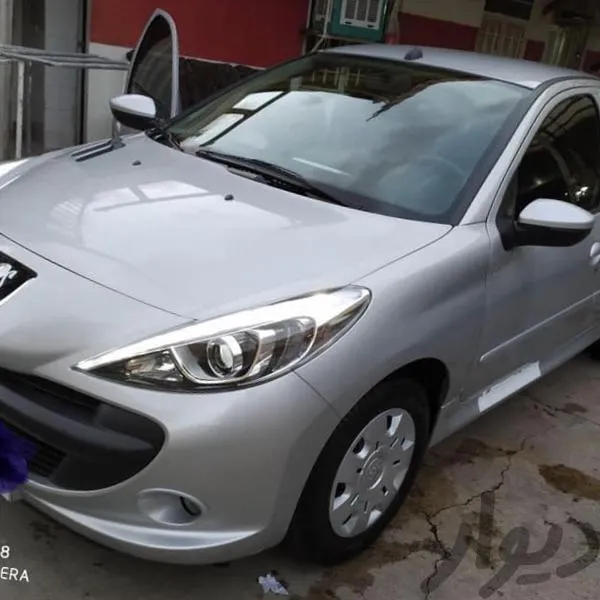

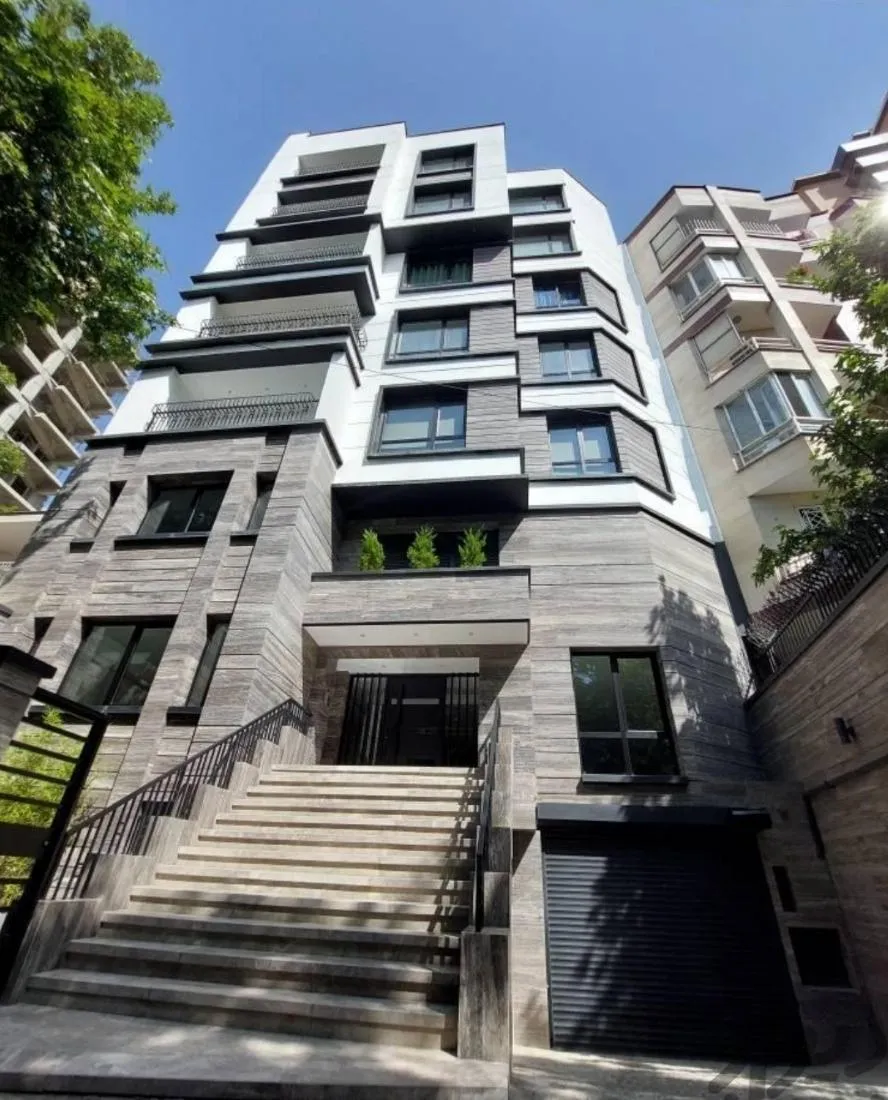

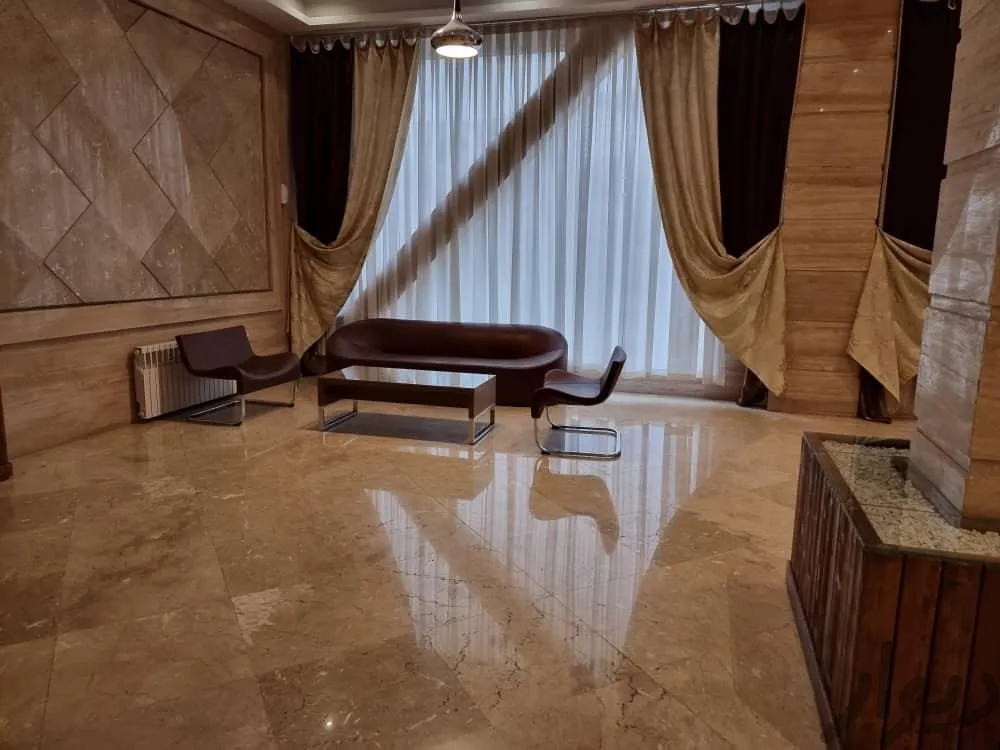

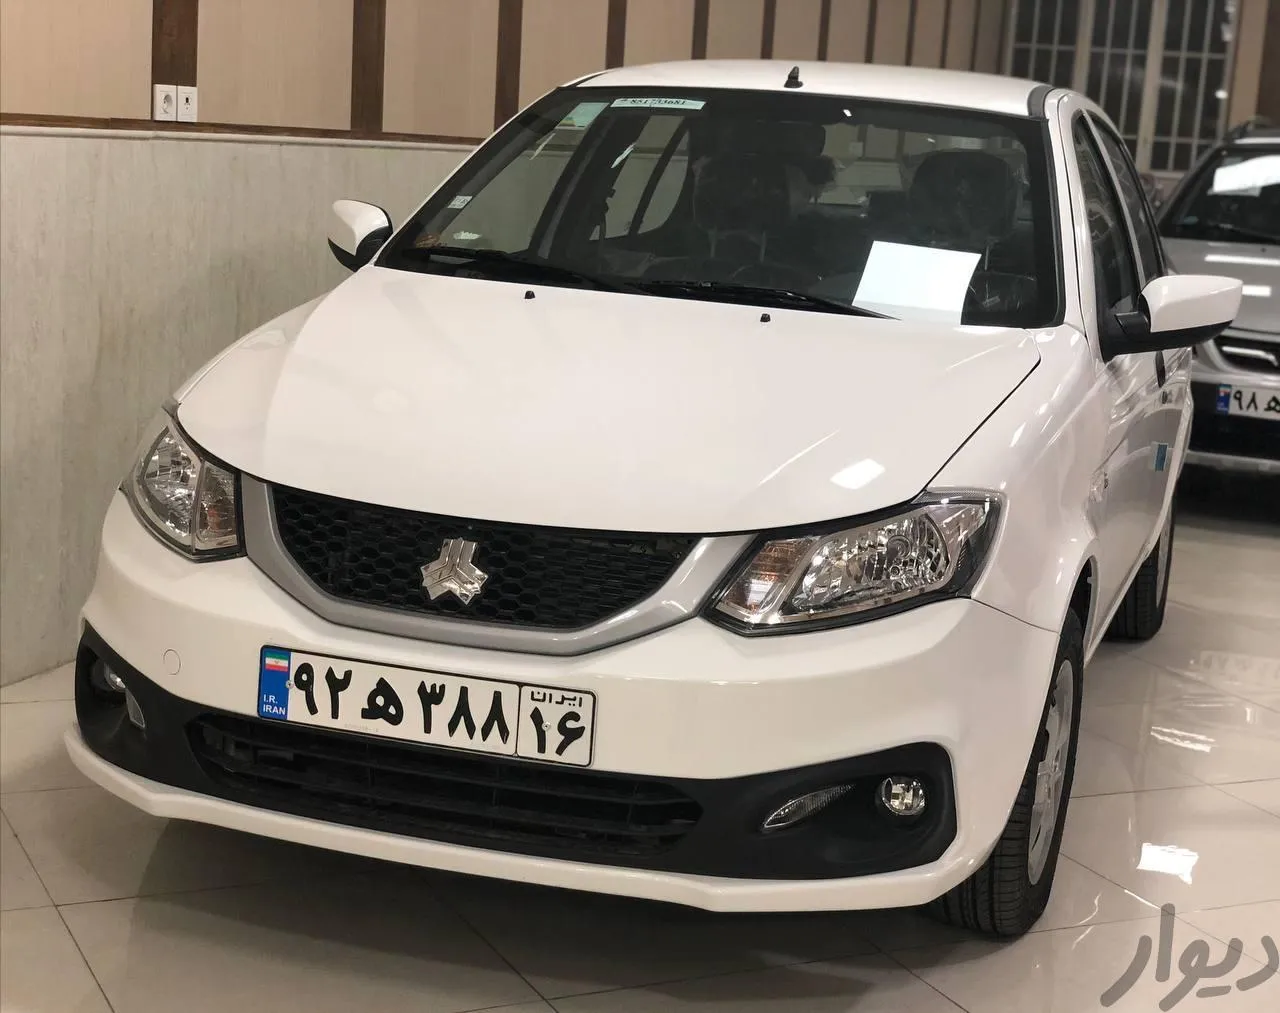

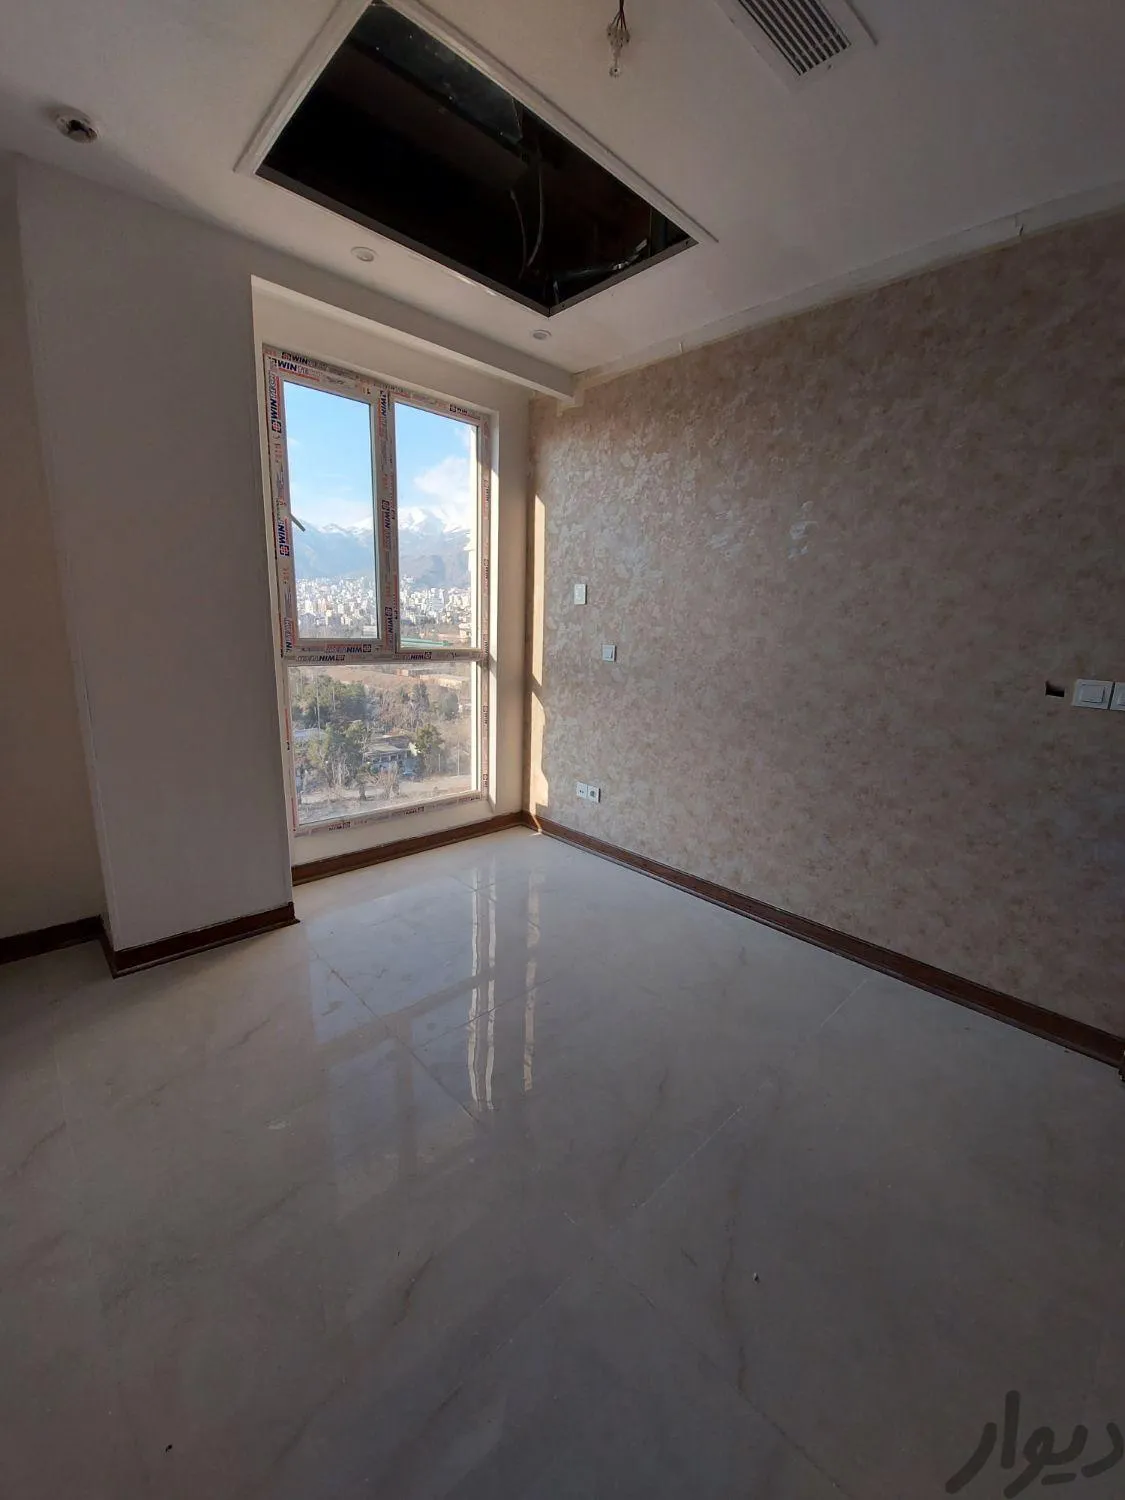

In [ ]:
import torch
import glob
from PIL import Image
from img2vec import Img2Vec
from model import Corrnet
import numpy as np
import pickle
from utils import predict
from preprocessing import Preprocessor
from utils_word2vec import text_standardization
from IPython.display import display
from IPython.display import Image as Img


class ImageSearchDemo:
    def __init__(self):
        self.img2vec = Img2Vec('resnet-18', 'default', 512, cuda=True)
        self.w2v_weights = np.load("/content/w2v_embedding.npz")['arr_0']
        self.w2v_vocabs = pickle.load(open("/content/vocabs.pkl", "rb"))
        self.preprocessor = Preprocessor()
        self.model_save_path = '/content/model_state.pt'
        self.corrnet = Corrnet(512, 50)
        self.corrnet.load_state_dict(torch.load(self.model_save_path))
        self.corrnet.eval()

    def compute_text_embedding(self, query: str, embedding_dim=512):
        query_embedding = None
        tf_cleaned_input = text_standardization(query, self.preprocessor)

        v = np.array([0. for i in range(embedding_dim)])
        l = 0
        for word in (tf_cleaned_input.numpy()).decode('utf-8').split():
            word = '[UNK]' if word not in self.w2v_vocabs.keys() else word
            v += self.w2v_weights[self.w2v_vocabs[word]]
            l += 1
        query_embedding = v / l

        return query_embedding

    def image_search(self, query: str, image_name_set, top_num):
        query_embedding = self.compute_text_embedding(query=query)
        img_array = np.zeros((len(image_name_set), 512))
        for i in range(len(image_name_set)):
            img = Image.open(image_name_set[i]).convert('RGB')
            img_array[i] = self.img2vec.get_vec(img)

        txt_array = np.zeros((len(image_name_set), 512))
        for j in range(len(image_name_set)):
            txt_array[j] = query_embedding

        predictions = list(
            predict(self.corrnet, torch.from_numpy(txt_array.astype(np.float32)), torch.from_numpy(img_array.astype(np.float32)))[1])

        predictions_dict = dict(zip(image_name_set, predictions))
        predictions_dict = dict(sorted(predictions_dict.items(), key=lambda item: item[1]))
        if len(list(predictions_dict.keys())) > top_num:
            return list(predictions_dict.keys())[0:top_num]
        return predictions_dict.keys()


if __name__ == '__main__':
    image_demo = ImageSearchDemo()
    text = ' خانه آپارتمان در شمال تهران'
    image_name_set = glob.glob('/content/images/*.jpg')
    
    top_num = 5
    predictions_image_pathes = image_demo.image_search(text, image_name_set, top_num)
    for img_path in predictions_image_pathes:
        display(Img(img_path, width=100, height=100))
